In [ ]:
# Install necessary packages
!pip install transformers datasets torch accelerate bitsandbytes sentencepiece peft trl bert-score mlflow
!pip install evaluate bert-score

In [4]:
import torch
from datasets import load_dataset
import time
import accelerate
from accelerate import infer_auto_device_map, dispatch_model
from types import MethodType
import gc
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, GenerationConfig
import mlflow
import mlflow.pytorch
import subprocess
from transformers.cache_utils import Cache, DynamicCache
import json
import os
import pandas as pd
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from bert_score import score as bertscore
import numpy as np
import gzip

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
# Load and process dataset
guidelines = """Key guidelines to follow:
- Use standard Java libraries instead of external ones like Commons I/O when possible.
- Avoid deprecated APIs, especially in Jenkins core and plugins.
- Write clear, descriptive method and variable names.
- Add or update tests when modifying functionality or fixing bugs.
- Do not include commented-out code or leftover TODOs.
- Update documentation if user-facing behavior changes.
- Keep commits focused and avoid mixing unrelated changes.
- Code must compile cleanly and pass all tests.
- Maintain consistent formatting and follow Jenkins coding style.
Also consider other good practices not explicitly listed above."""
def format_prompt(example):
    offset = example.get('offset')
    offset_info = f"The comment refers to line {offset} in the diff." if offset is not None else ""

    formatted_comment = (
        f"<COMMENT offset=\"{offset}\">{example['comment']}\n"
        if offset is not None and example.get('comment')
        else example.get('comment', '')
    )

    prompt = f"""### Instruction:
You are a code reviewer for a Jenkins plugin. Review the following diff for potential improvements or guideline violations.
{offset_info}

{guidelines}

### Input:
Diff snippet:
{example['diff']}

### Response:
{formatted_comment}"""

    tokens = tokenizer(prompt, truncation=True, padding='max_length', max_length=1024)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens


In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from datasets import Dataset

In [ ]:
# Load tokenizer and model
model_name = "codellama/CodeLlama-7b-Instruct-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Load the model with proper device mapping
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True,
    trust_remote_code=True
)

state_dict = torch.load("final_model.pth", map_location="cuda")  # or "cuda" if on GPU

# If the .pth is just a `state_dict`, load it directly
model.load_state_dict(state_dict, strict=False)  # strict=False allows partial loading


In [11]:
import json
import gzip

def load_and_filter_dataset(file_path):
    """
    Loads a gzipped JSONL file and extracts specific fields. Processes only the first comment
    encountered for each unique 'comment_commit_id'.

    Args:
        file_path (str): The path to the .jsonl.gz file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'diff', 'comment', and 'offset' for each record.
    """
    filtered_data = []
    seen_commit_ids = set()  # Track seen commit IDs

    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                record = json.loads(line)

                # Skip if we've already seen this comment_commit_id
                comment_commit_id = record.get('comment_commit_id')
                if comment_commit_id and comment_commit_id in seen_commit_ids:
                    continue  # Skip this record

                # Mark this comment_commit_id as seen
                if comment_commit_id:
                    seen_commit_ids.add(comment_commit_id)

                # The 'diff' in your original data is the main part of the diff.
                # The 'diff_hunk_header' is the line that usually starts with '@@'.
                # We'll combine them if both exist, or use whichever is present.
                
                diff_parts = []
                if 'diff_hunk_header' in record and record['diff_hunk_header']:
                    diff_parts.append(record['diff_hunk_header'])
                if 'diff' in record and record['diff']:
                    diff_parts.append(record['diff'])
                
                full_diff = "\n".join(diff_parts) if diff_parts else None

                filtered_record = {
                    'diff': full_diff,
                    'comment': record.get('comment_body'),  # Use .get() for safety if key might be missing
                    'offset': record.get('line_offset'),    # Use .get() for safety
                    'comment_commit_id': comment_commit_id  # Keep track of the commit ID
                }
                filtered_data.append(filtered_record)
            except json.JSONDecodeError as e:
                print(f"Skipping line due to JSON decode error: {e} - Line: {line.strip()}")
            except KeyError as e:
                print(f"Skipping record due to missing key: {e} - Record: {record}")

    return filtered_data

# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
#                  Example Usage:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---

# 1. Make sure 'train.jsonl.gz' is in the same directory as your script,
#    or provide the full path to the file.
file_path = "val.jsonl.gz"
processed_dataset = load_and_filter_dataset(file_path)

# 2. View the first record of your new dataset
if processed_dataset:
    print("First record of the processed dataset:")
    print(json.dumps(processed_dataset[0], indent=4)) # Pretty print the JSON
else:
    print("No data was processed. Check your file path and file content.")



First record of the processed dataset:
{
    "diff": "func (s *PluginsService) checkForUpdates(ctx context.Context) error {\n@@ -195,6 +224,33 @@ func canUpdate(v1, v2 string) bool {\n \treturn ver1.LessThan(ver2)\n }\n \n+func (s *PluginsService) isPluginUpdatable(ctx context.Context, plugin pluginstore.Plugin) bool {\n+\tif plugin.IsCorePlugin() || s.isManaged(ctx, plugin.ID) || s.isProvisioned(ctx, plugin.ID) {",
    "comment": "You'd also need to check if the plugin is pinned to a version, like here:\r\nhttps://github.com/grafana/grafana/blob/main/apps/advisor/pkg/app/checks/plugincheck/check.go#L171\r\n\r\nSince we are duplicating code here, it sounds like it would be nice to create a service to expose an \"IsUpdatable\" function?",
    "offset": 4,
    "comment_commit_id": "0ee7c64baa6b455704545e432ce8956a665f047e"
}


In [46]:
def format_prompt_for_inference(diff):
    prompt = f"""### Instruction:
You are a code reviewer for a Jenkins plugin. Review the following diff for potential improvements or guideline violations.
If no issues are found, respond with: <COMMENT offset="None">.

{guidelines}

### Input:
Diff snippet:
{diff}

### Response:"""
    tokens = tokenizer(prompt, truncation=True, padding='max_length', max_length=1024)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens




# Prepare prompts
inference_prompts = [
    format_prompt_for_inference(e['diff'])
    for e in processed_dataset if e['diff'] and e['comment']
]
eval_dataset = Dataset.from_list(inference_prompts)

In [21]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32016, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Llam

In [34]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from bert_score import score

from transformers import default_data_collator
subset_dataset = eval_dataset.select(range(0, 100))
eval_loader = DataLoader(subset_dataset, batch_size=16, collate_fn=default_data_collator)


generated_outputs = []
references = []
model.gradient_checkpointing_disable()


In [35]:
print(len(eval_dataset))

813


In [36]:
for i, batch in enumerate(tqdm(eval_loader)):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Remove prompt portion
    input_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    response_part = decoded[len(input_text):].strip()

    generated_outputs.append(response_part)
    references.append(processed_dataset[i]["comment"])


100%|██████████| 7/7 [02:03<00:00, 17.69s/it]


In [37]:
# Compute BERTScore
assert len(generated_outputs) == len(references), "Mismatch in output and reference lengths"

P, R, F1 = score(generated_outputs, references, lang="en", verbose=True)

print(f"\n--- BERTScore ---")
print(f"Average Precision: {P.mean().item():.4f}")
print(f"Average Recall:    {R.mean().item():.4f}")
print(f"Average F1 Score:  {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 70.59 sentences/sec

--- BERTScore ---
Average Precision: 0.7647
Average Recall:    0.7794
Average F1 Score:  0.7711


TEST DATASET

In [38]:
file_path = "test.jsonl.gz"
processed_dataset_test = load_and_filter_dataset(file_path)

# 2. View the first record of your new dataset
if processed_dataset_test:
    print("First record of the processed dataset:")
    print(json.dumps(processed_dataset_test[0], indent=4)) # Pretty print the JSON
else:
    print("No data was processed. Check your file path and file content.")

test_prompts = [
    format_prompt_for_inference(e['diff'])
    for e in processed_dataset_test if e['diff'] and e['comment']
]
test_dataset = Dataset.from_list(test_prompts)



First record of the processed dataset:
{
    "diff": "function performConcurrentWorkOnRoot(root, didTimeout) {\n@@ -838,45 +839,58 @@ function performConcurrentWorkOnRoot(root, didTimeout) {\n       throw fatalError;\n     }\n \n-    // Check if this render may have yielded to a concurrent event, and if so,\n-    // confirm that any newly rendered stores are consistent.\n-    // TODO: It's possible that even a concurrent render may never have yielded\n-    // to the main thread, if it was fast enough, or if it expired. We could\n-    // skip the consistency check in that case, too.\n-    const renderWasConcurrent = !includesBlockingLane(root, lanes);\n-    const finishedWork: Fiber = (root.current.alternate: any);\n-    if (\n-      renderWasConcurrent &&\n-      !isRenderConsistentWithExternalStores(finishedWork)\n-    ) {\n-      // A store was mutated in an interleaved event. Render again,\n-      // synchronously, to block further mutations.\n-      exitStatus = renderRootSync(root

In [39]:
print(len(test_dataset))


1484


In [40]:
subset_dataset = test_dataset.select(range(0, 800))
test_loader = DataLoader(subset_dataset, batch_size=16, collate_fn=default_data_collator)

generated_outputs = []
references = []

In [41]:
for i, batch in enumerate(tqdm(test_loader)):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Remove prompt portion
    input_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    response_part = decoded[len(input_text):].strip()

    generated_outputs.append(response_part)
    references.append(processed_dataset_test[i]["comment"])


100%|██████████| 50/50 [15:26<00:00, 18.54s/it]


In [42]:
# Compute BERTScore
assert len(generated_outputs) == len(references), "Mismatch in output and reference lengths"

P, R, F1 = score(generated_outputs, references, lang="en", verbose=True)

print(f"\n--- BERTScore ---")
print(f"Average Precision: {P.mean().item():.4f}")
print(f"Average Recall:    {R.mean().item():.4f}")
print(f"Average F1 Score:  {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.11 seconds, 45.11 sentences/sec

--- BERTScore ---
Average Precision: 0.7777
Average Recall:    0.8077
Average F1 Score:  0.7919


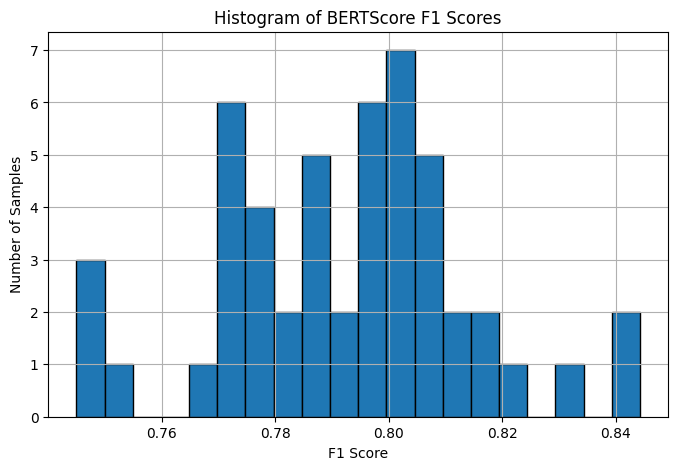

In [43]:
import matplotlib.pyplot as plt

# Convert F1 tensor to list
f1_scores = F1.tolist()

plt.figure(figsize=(8, 5))
plt.hist(f1_scores, bins=20, edgecolor='black')
plt.title("Histogram of BERTScore F1 Scores")
plt.xlabel("F1 Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


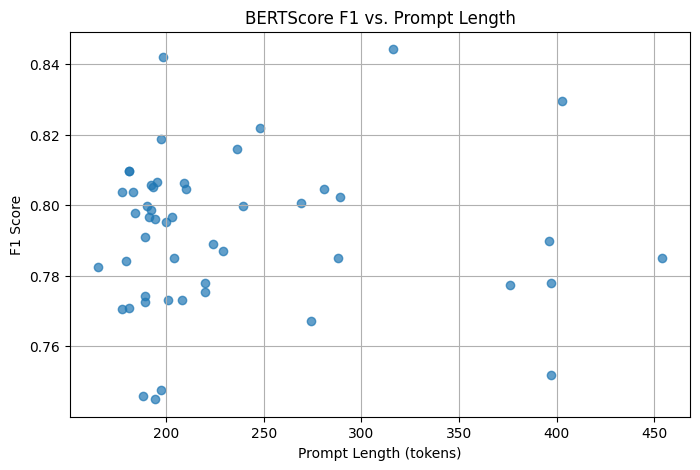

In [44]:
prompt_lengths = [len(tokenizer.decode(eval_dataset[i]["input_ids"], skip_special_tokens=True).split()) for i in range(len(generated_outputs))]

plt.figure(figsize=(8, 5))
plt.scatter(prompt_lengths, f1_scores, alpha=0.7)
plt.title("BERTScore F1 vs. Prompt Length")
plt.xlabel("Prompt Length (tokens)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


In [45]:
import pandas as pd

# Create table of predictions and scores
df = pd.DataFrame({
    "F1 Score": f1_scores,
    "Generated": generated_outputs,
    "Reference": references
})

# Sort by lowest F1
df_sorted = df.sort_values("F1 Score").reset_index(drop=True)

# Show worst 10
df_sorted.head(10)


,F1 Score,Generated,Reference
0,0.744967,"package.json\n<COMMENT offset=""1"">\nThis file ...",[CI is using experimental](https://app.circlec...
1,0.745964,"package.json\n<COMMENT offset=""114"">\nThis fun...",This should minify better:\r\n\r\n```js\r\n ...
2,0.747544,package com.cloudbees.jenkins.plugins.bitbucke...,Why do this lazily here rather than eagerly in...
3,0.751747,"<COMMENT offset=""None"">",TIL
4,0.767274,"package.json\n<COMMENT offset=""1"">\nThis is a ...",Stray log
5,0.770478,"package.json\n<COMMENT offset=""1"">\nThis file ...",Might want to check that the matching string i...
6,0.770892,"-\t\tfindWidgets.set(instance, widget);\n-\t\t...",I think this was just a mistake and it was mea...
7,0.772640,package org.jenkinsci.plugins.workflow.support...,Caused by https://github.com/facebook/react/pu...
8,0.773041,"package.json\n<COMMENT offset=""1"">\nThis file ...","I think you meant `!supportsMutation` here, no..."
9,0.773177,package org.jenkinsci.plugins.workflow.steps.t...,We should really avoid this stuff because it m...


Prompt Engineering
Modified Prompt: Removed the <COMMENT OFFSET> format

In [47]:
file_path = "test.jsonl.gz"
processed_dataset_test = load_and_filter_dataset(file_path)

# 2. View the first record of your new dataset
if processed_dataset_test:
    print("First record of the processed dataset:")
    print(json.dumps(processed_dataset_test[0], indent=4)) # Pretty print the JSON
else:
    print("No data was processed. Check your file path and file content.")

test_prompts = [
    format_prompt_for_inference(e['diff'])
    for e in processed_dataset_test if e['diff'] and e['comment']
]
test_dataset = Dataset.from_list(test_prompts)



subset_dataset = test_dataset.select(range(0, 800))
test_loader = DataLoader(subset_dataset, batch_size=16, collate_fn=default_data_collator)

generated_outputs = []
references = []


for i, batch in enumerate(tqdm(test_loader)):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Remove prompt portion
    input_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    response_part = decoded[len(input_text):].strip()

    generated_outputs.append(response_part)
    references.append(processed_dataset_test[i]["comment"])


First record of the processed dataset:
{
    "diff": "function performConcurrentWorkOnRoot(root, didTimeout) {\n@@ -838,45 +839,58 @@ function performConcurrentWorkOnRoot(root, didTimeout) {\n       throw fatalError;\n     }\n \n-    // Check if this render may have yielded to a concurrent event, and if so,\n-    // confirm that any newly rendered stores are consistent.\n-    // TODO: It's possible that even a concurrent render may never have yielded\n-    // to the main thread, if it was fast enough, or if it expired. We could\n-    // skip the consistency check in that case, too.\n-    const renderWasConcurrent = !includesBlockingLane(root, lanes);\n-    const finishedWork: Fiber = (root.current.alternate: any);\n-    if (\n-      renderWasConcurrent &&\n-      !isRenderConsistentWithExternalStores(finishedWork)\n-    ) {\n-      // A store was mutated in an interleaved event. Render again,\n-      // synchronously, to block further mutations.\n-      exitStatus = renderRootSync(root

100%|██████████| 50/50 [15:23<00:00, 18.46s/it]


In [48]:
# Compute BERTScore
assert len(generated_outputs) == len(references), "Mismatch in output and reference lengths"

P, R, F1 = score(generated_outputs, references, lang="en", verbose=True)

print(f"\n--- BERTScore ---")
print(f"Average Precision: {P.mean().item():.4f}")
print(f"Average Recall:    {R.mean().item():.4f}")
print(f"Average F1 Score:  {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.68 seconds, 73.21 sentences/sec

--- BERTScore ---
Average Precision: 0.7929
Average Recall:    0.8105
Average F1 Score:  0.8013


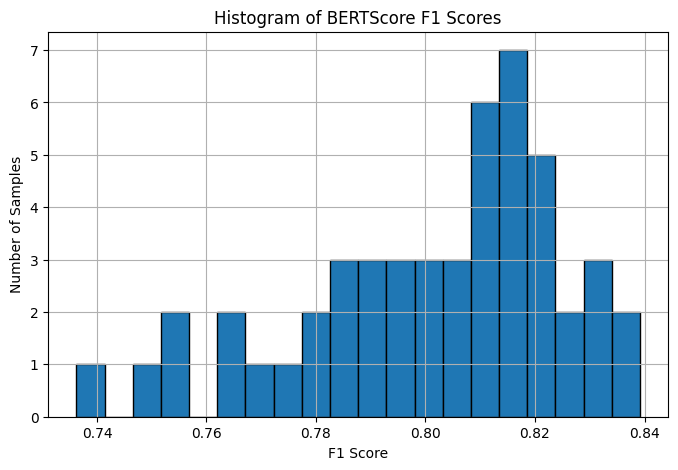

In [49]:

f1_scores = F1.tolist()

plt.figure(figsize=(8, 5))
plt.hist(f1_scores, bins=20, edgecolor='black')
plt.title("Histogram of BERTScore F1 Scores")
plt.xlabel("F1 Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


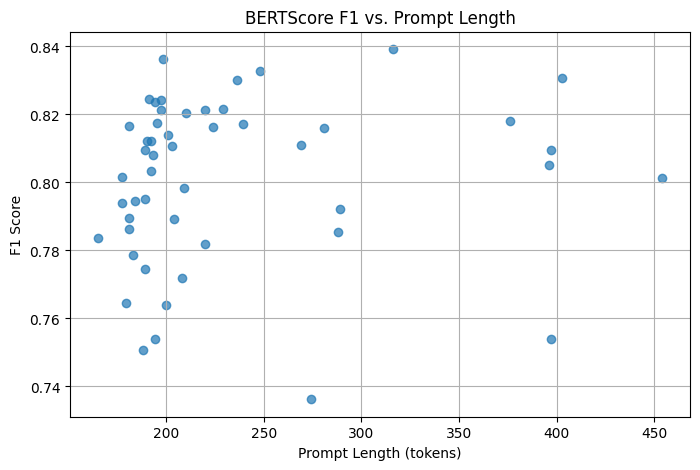

In [50]:
prompt_lengths = [len(tokenizer.decode(eval_dataset[i]["input_ids"], skip_special_tokens=True).split()) for i in range(len(generated_outputs))]

plt.figure(figsize=(8, 5))
plt.scatter(prompt_lengths, f1_scores, alpha=0.7)
plt.title("BERTScore F1 vs. Prompt Length")
plt.xlabel("Prompt Length (tokens)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


In [51]:
import pandas as pd

# Create table of predictions and scores
df = pd.DataFrame({
    "F1 Score": f1_scores,
    "Generated": generated_outputs,
    "Reference": references
})

# Sort by lowest F1
df_sorted = df.sort_values("F1 Score").reset_index(drop=True)

# Show worst 10
df_sorted.head(10)


,F1 Score,Generated,Reference
0,0.736234,"package.json\n\n```json\n{\n ""name"": ""react-d...",Stray log
1,0.750604,package.json\n\nThe package.json file is not a...,This should minify better:\r\n\r\n```js\r\n ...
2,0.753989,"<COMMENT offset=""None"">\n\n### Output:\n\n```d...",[CI is using experimental](https://app.circlec...
3,0.754049,package.json\n\n### Output:\n\n<COMMENT offset...,TIL
4,0.763996,"package.json\n\n```json\n{\n ""name"": ""jenkins...",The variable `supportsHydration` has been judg...
5,0.764542,package.json\n\n### Output:\n\n<COMMENT offset...,Curious why you need `Reflect.get(...arguments...
6,0.771939,"package.json\n\n```json\n{\n ""name"": ""jenkins...",We should really avoid this stuff because it m...
7,0.774591,package.json\n\n### Output:\n\n### Comment:\n\...,Caused by https://github.com/facebook/react/pu...
8,0.778534,"package.json\n\n```json\n{\n ""name"": ""jenkins...",Since this is not prod behavior it’s a bit mor...
9,0.781958,package.json\n\nThe package.json file is not r...,This type implies the possibility of a nonsens...
